In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
df = yf.download('BBCA.JK',
                 start = '2004-06-08',
                 end= '2022-05-08')
d1 = pd.DataFrame(df['Adj Close'])
d1.rename(columns={'Adj Close':'adj_close'}, inplace=True)
d1['simple_rtn']=d1.adj_close.pct_change()
d1.head()

[*********************100%***********************]  1 of 1 completed


,adj_close,simple_rtn
Date,,
2004-06-08,108.704865,NaN
2004-06-09,110.235916,0.014084
2004-06-10,110.235916,0.000000
2004-06-11,110.235916,0.000000
2004-06-14,108.704865,-0.013889


In [ ]:
d1[['mean', 'std']] = d1['simple_rtn'].ewm(span=21) \
                               .agg(['mean', 'std'])
d1.head()

,adj_close,simple_rtn,mean,std
Date,,,,
2004-06-08,108.704865,NaN,NaN,NaN
2004-06-09,110.235916,0.014084,0.014084,NaN
2004-06-10,110.235916,0.000000,0.006707,0.009959
2004-06-11,110.235916,0.000000,0.004255,0.007933
2004-06-14,108.704865,-0.013889,-0.000948,0.011404


In [ ]:
d1.dropna(inplace=True)

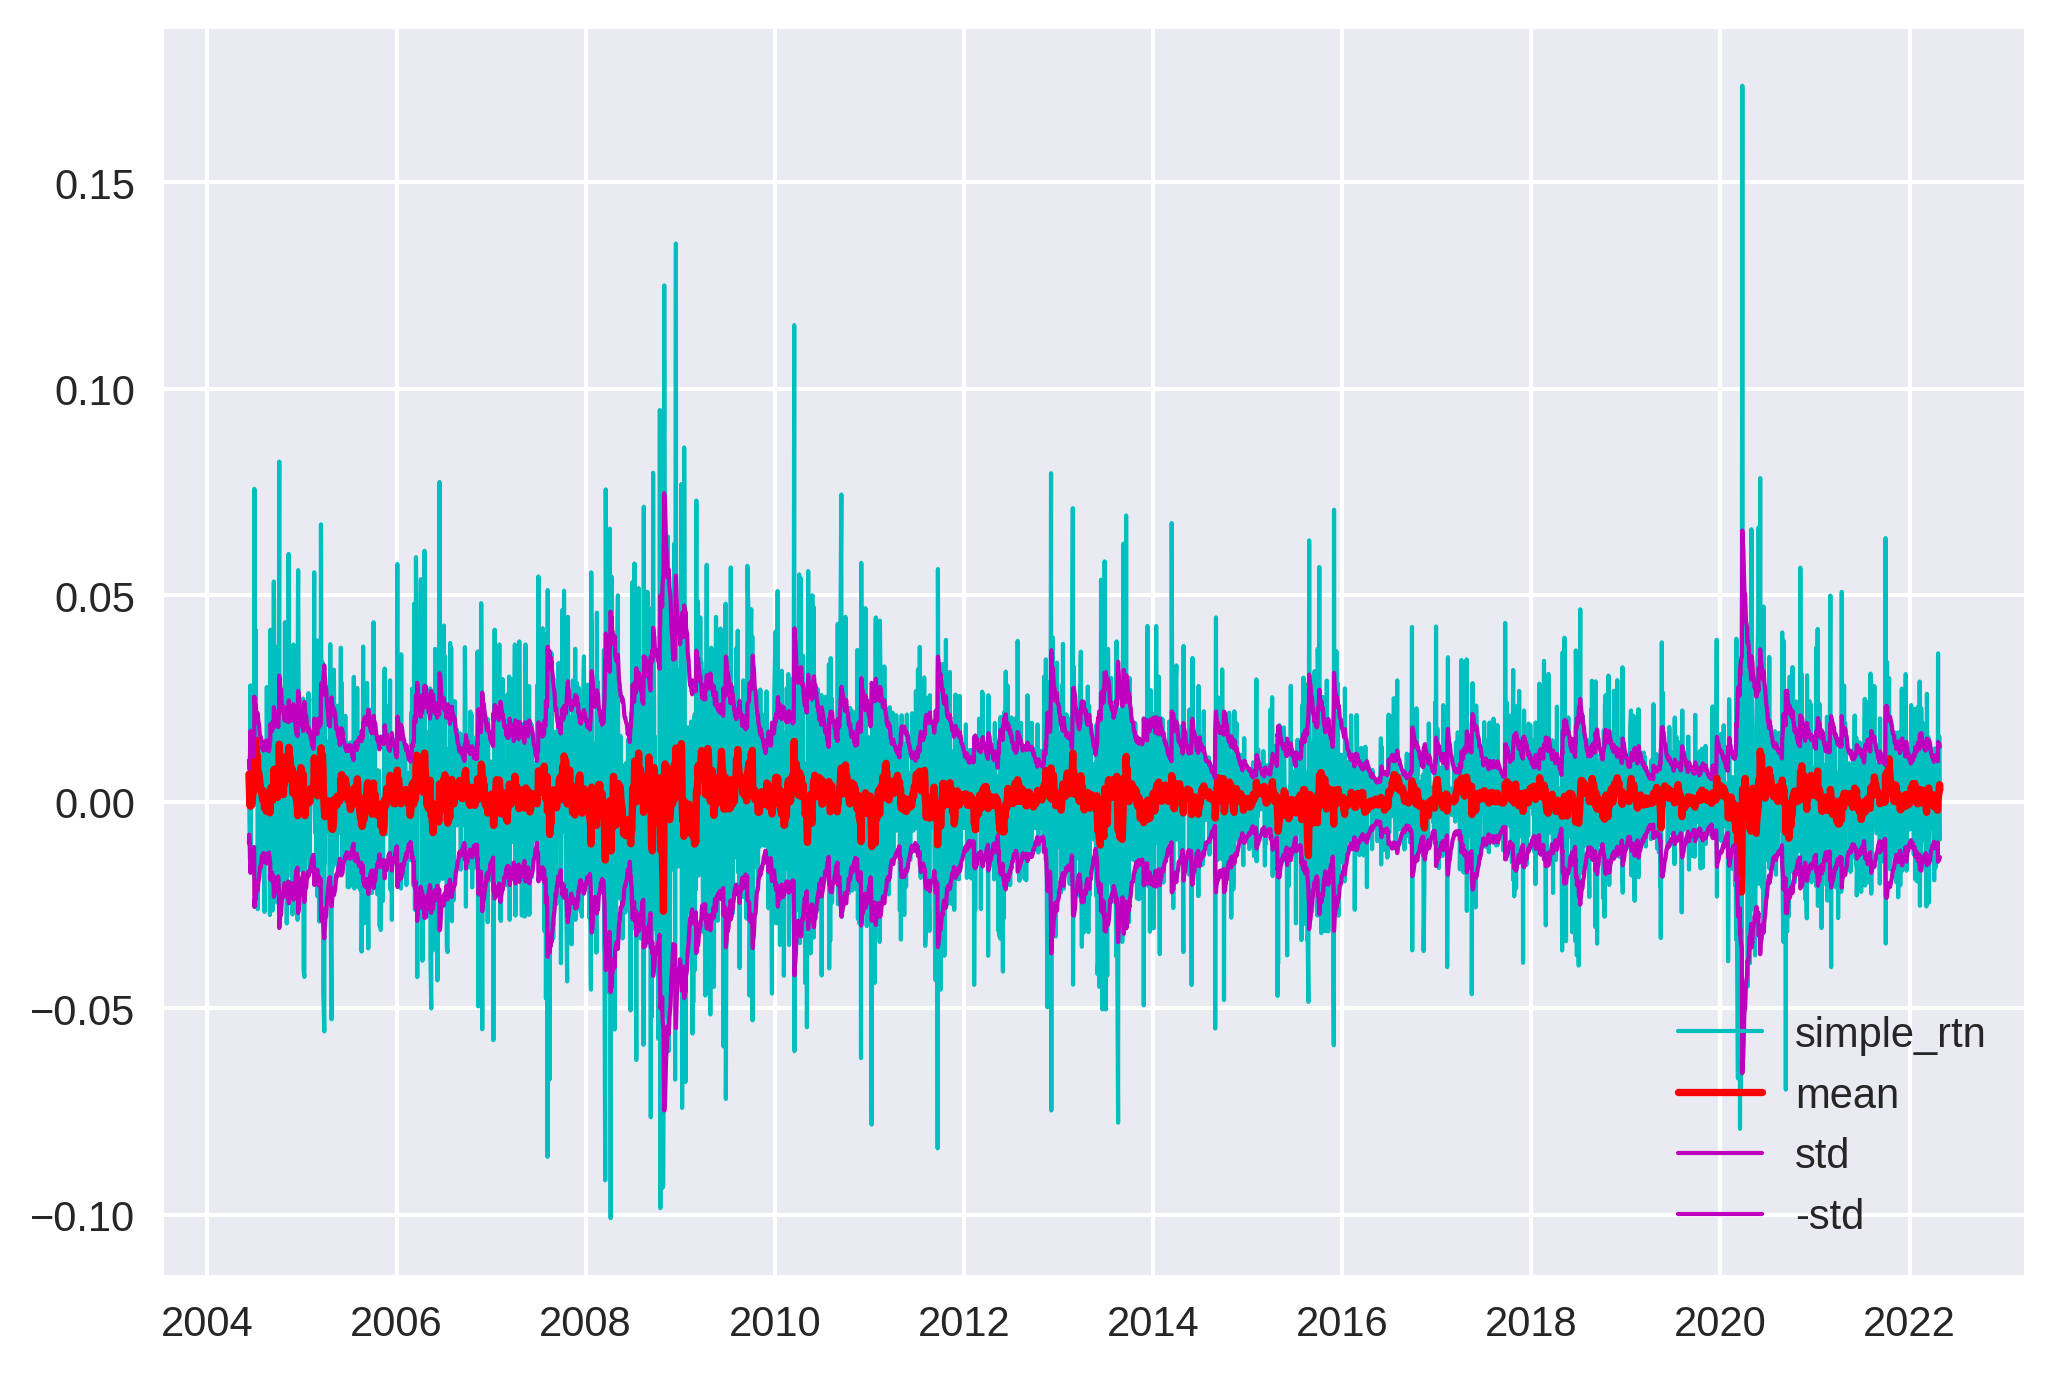

In [ ]:
fig, ax = plt.subplots()
ax.plot(d1.index, d1['simple_rtn'], label='simple_rtn',c='c', lw=1)
ax.plot(d1.index, d1['mean'], label= 'mean',c='r')
ax.plot(d1.index, d1[ 'std'], label= 'std',linestyle='-',c='m', lw=1 )
ax.plot(d1.index, -d1['std'],label='-std', linestyle='-',c='m', lw=1)
ax.legend(loc='lower right')

In [ ]:
d1_mean = d1['simple_rtn'].agg(['mean', 'std'])

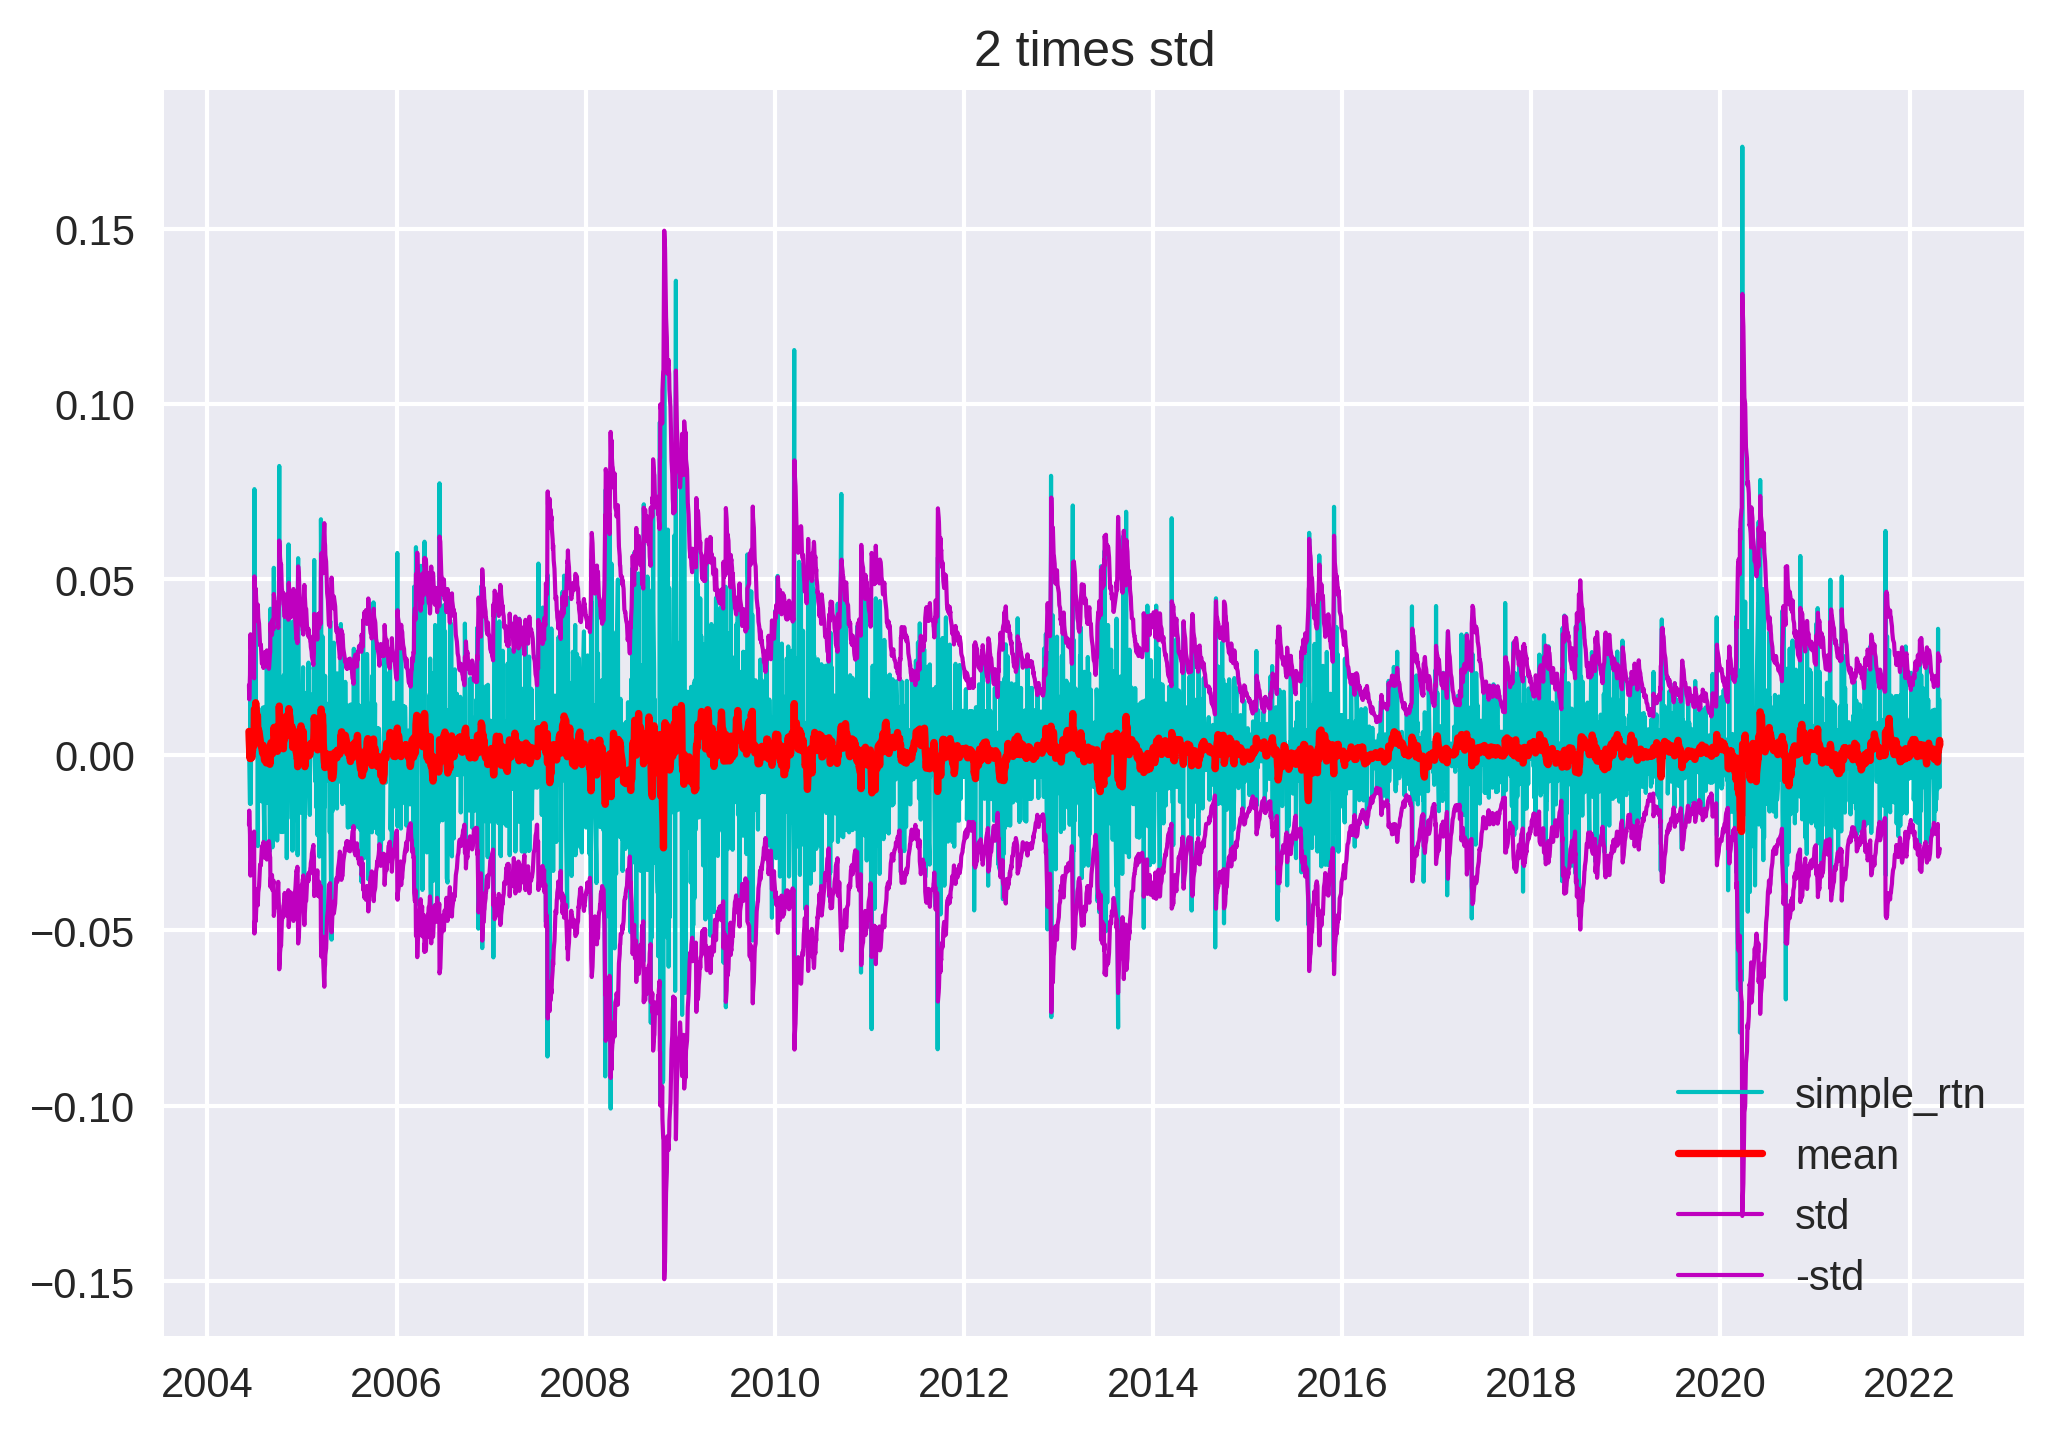

In [ ]:
fig, ax = plt.subplots()
ax.plot(d1.index, d1['simple_rtn'], label='simple_rtn',c='c', lw=1)
ax.plot(d1.index, d1['mean'], label= 'mean',c='r')
ax.plot(d1.index, 2*d1['std'], label= 'std',linestyle='-',c='m', lw=1 )
ax.plot(d1.index, -2*d1['std'],label='-std', linestyle='-',c='m', lw=1)
ax.set_title('2 times std')
ax.legend(loc='lower right')

In [ ]:
mu = d1_mean.loc['mean']
sigma = d1_mean.loc['std']
def get_outliers(df, mu=mu, sigma=sigma, n_sigmas=3):
    '''
    df: the DataFrame
    mu: mean
    sigmas: std
    n_sigmas: number of std as boundary
    '''
    x = df['simple_rtn']
    mu = mu
    sigma = sigma
    
    if (x > mu+n_sigmas*sigma) | (x<mu-n_sigmas*sigma):
        return 1
    else:
        return 0

In [ ]:
d1['outlier'] = d1.apply(get_outliers, axis=1)
d1.head()

,adj_close,simple_rtn,mean,std,outlier
Date,,,,,
2004-06-10,110.235916,0.000000,0.006707,0.009959,0
2004-06-11,110.235916,0.000000,0.004255,0.007933,0
2004-06-14,108.704865,-0.013889,-0.000948,0.011404,0
2004-06-15,111.766991,0.028169,0.006034,0.016936,0
2004-06-16,110.235916,-0.013699,0.001915,0.017194,0


In [ ]:
#The above code snippet can be refracted as follow:
import numpy as np
cond = (d1['simple_rtn'] > mu + sigma * 2) | (d1['simple_rtn'] < mu - sigma * 2)
d1['outliers'] = np.where(cond, 1, 0)

In [ ]:
d1.outlier.value_counts()

0    4376
1      66
Name: outlier, dtype: int64

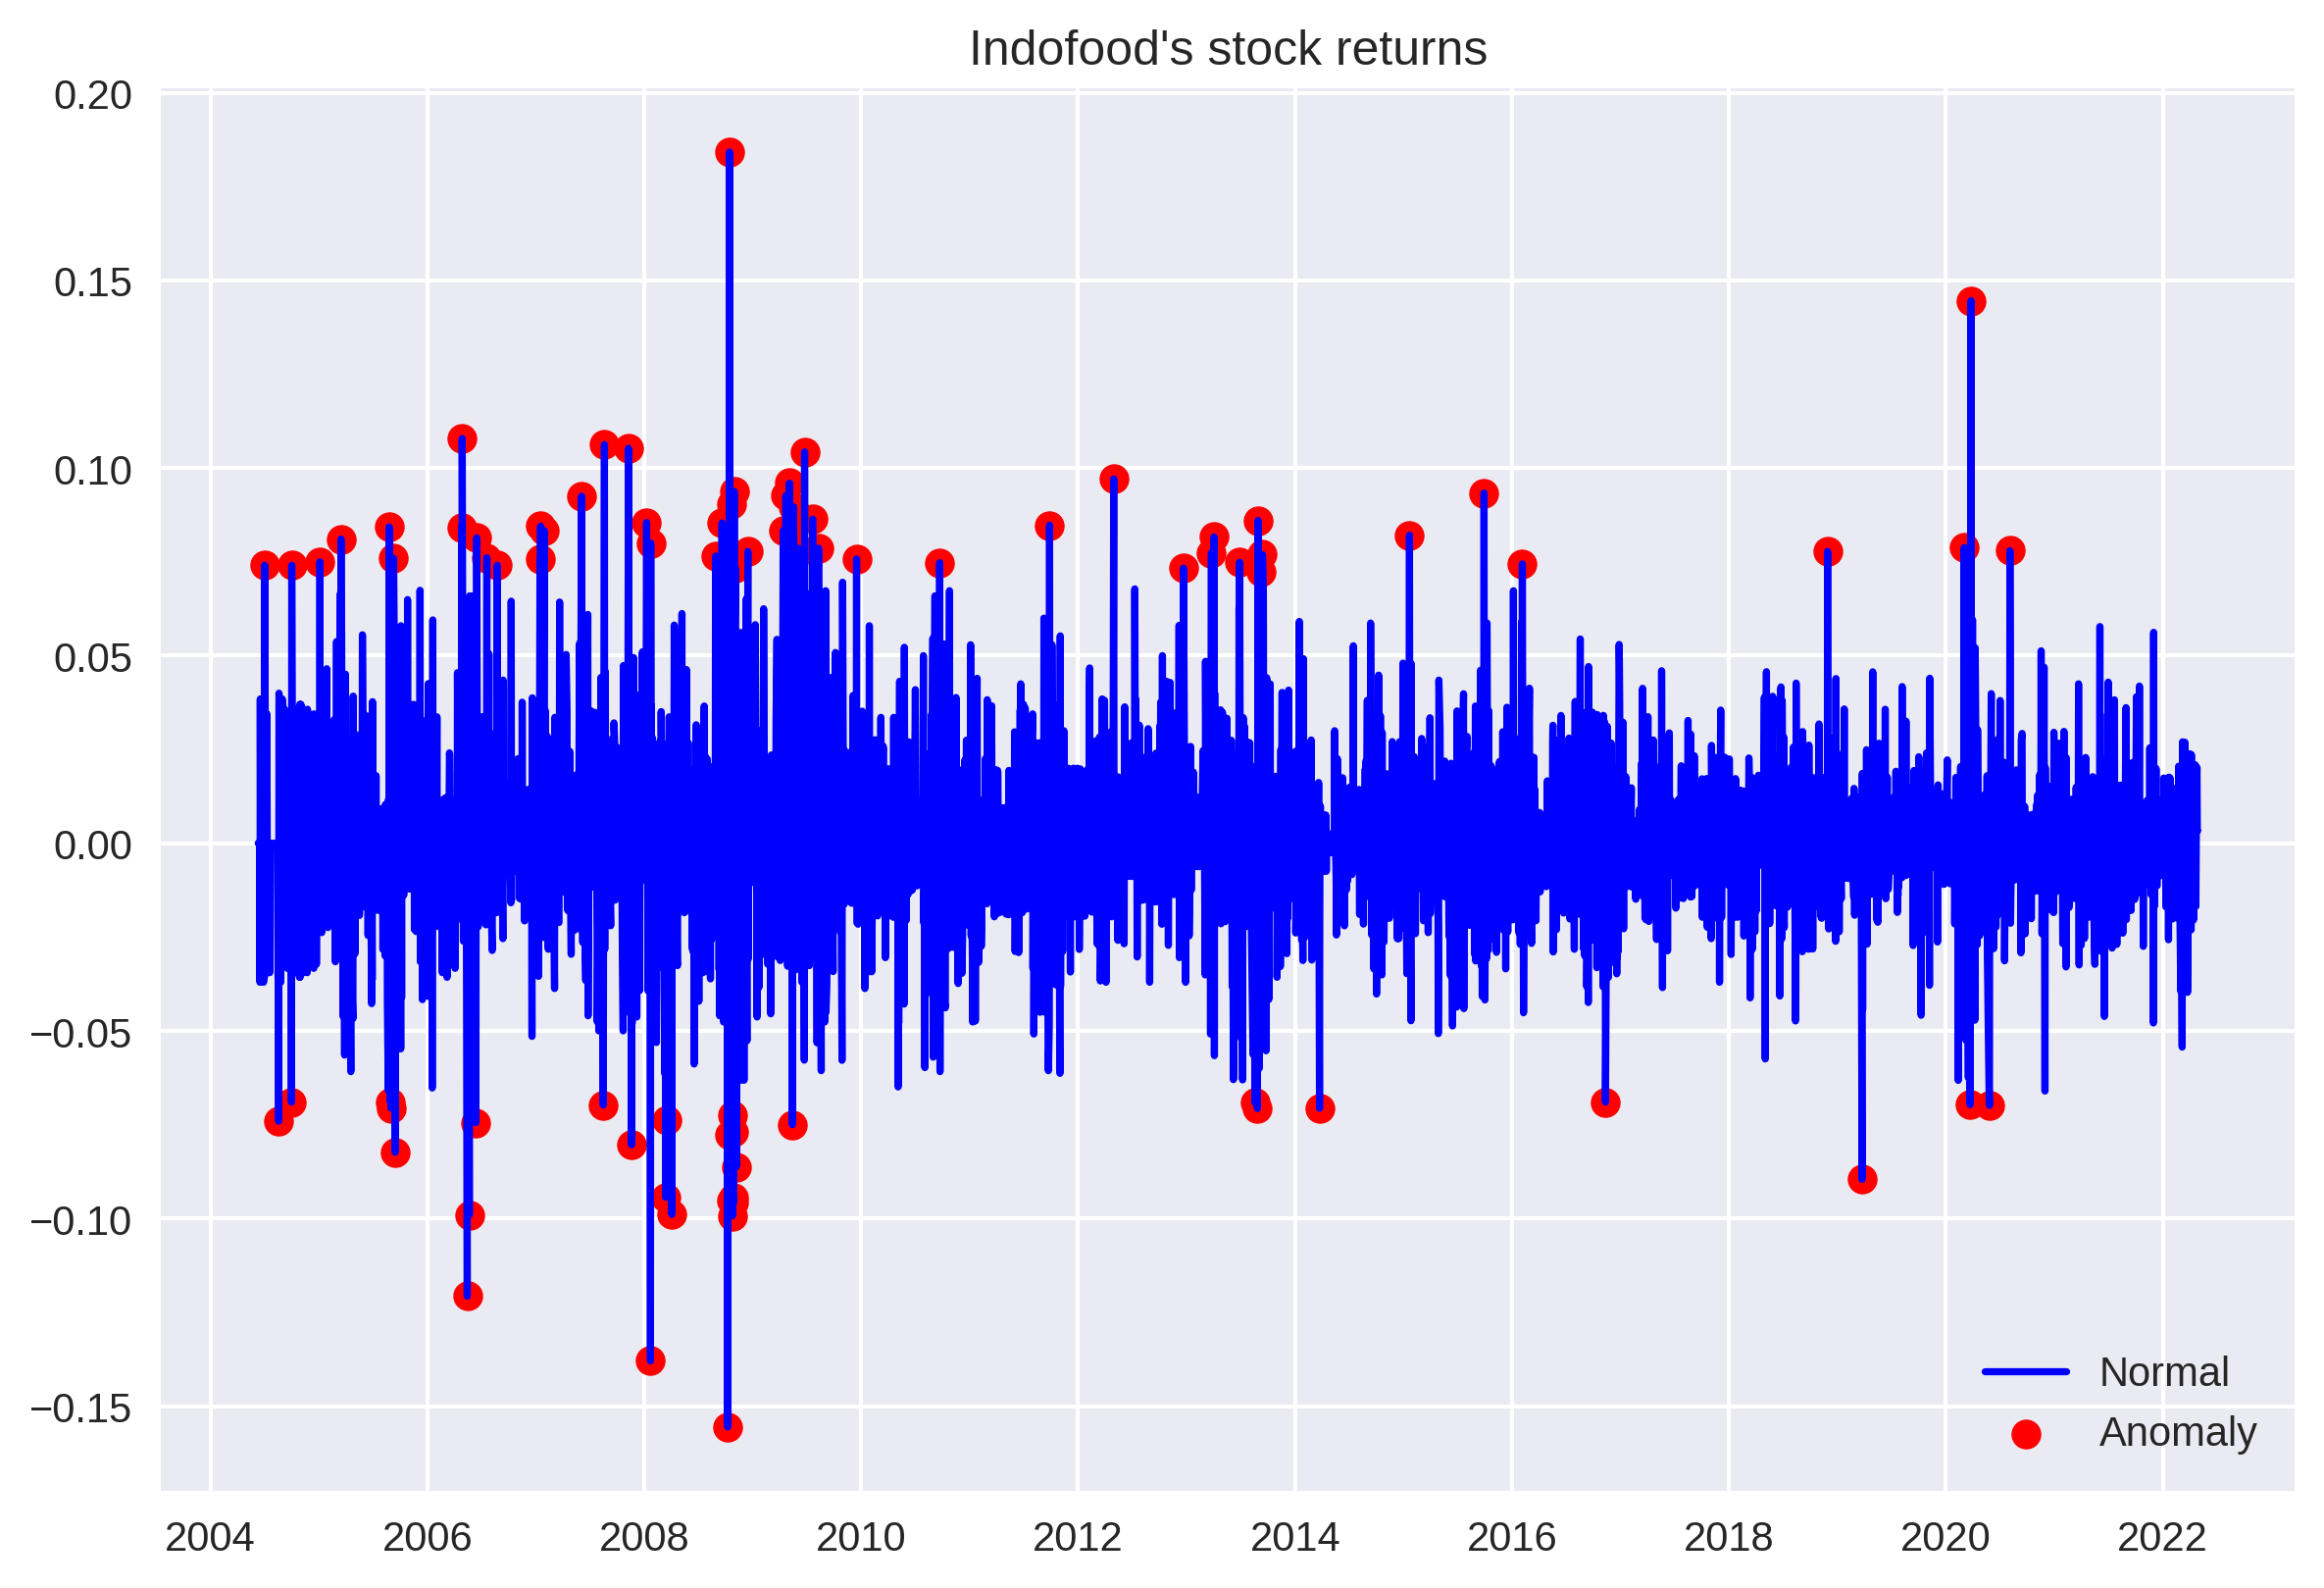

In [ ]:
outliers = d1.loc[d1['outlier'] == 1, ['simple_rtn']]
fig, ax = plt.subplots()
ax.plot(d1.index, d1.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly')
ax.set_title("Indofood CBP's stock returns")
ax.legend(loc='lower right')
plt.tight_layout()

plt.show()

In [ ]:
outlier_cutoff = 0.01
d1.pipe(lambda x:x.clip(lower=x.quantile(outlier_cutoff),
                        upper=x.quantile(1-outlier_cutoff),
                        axis=1,
                        inplace=True))
d1

,adj_close,simple_rtn,mean,std,outliers,outlier
Date,,,,,,
2004-06-10,274.93869,0.000000,0.000000,0.007787,0,0
2004-06-11,274.93869,0.000000,0.000000,0.007787,0,0
2004-06-14,274.93869,0.000000,0.000000,0.007787,0,0
2004-06-15,274.93869,0.000000,0.000000,0.007787,0,0
2004-06-16,274.93869,-0.037037,-0.007731,0.016532,0,0
...,...,...,...,...,...,...
2022-04-22,7300.00000,-0.016835,-0.001310,0.016600,0,0
2022-04-25,7425.00000,0.017123,0.000366,0.016733,0,0
2022-04-26,7575.00000,0.020202,0.002169,0.016991,0,0


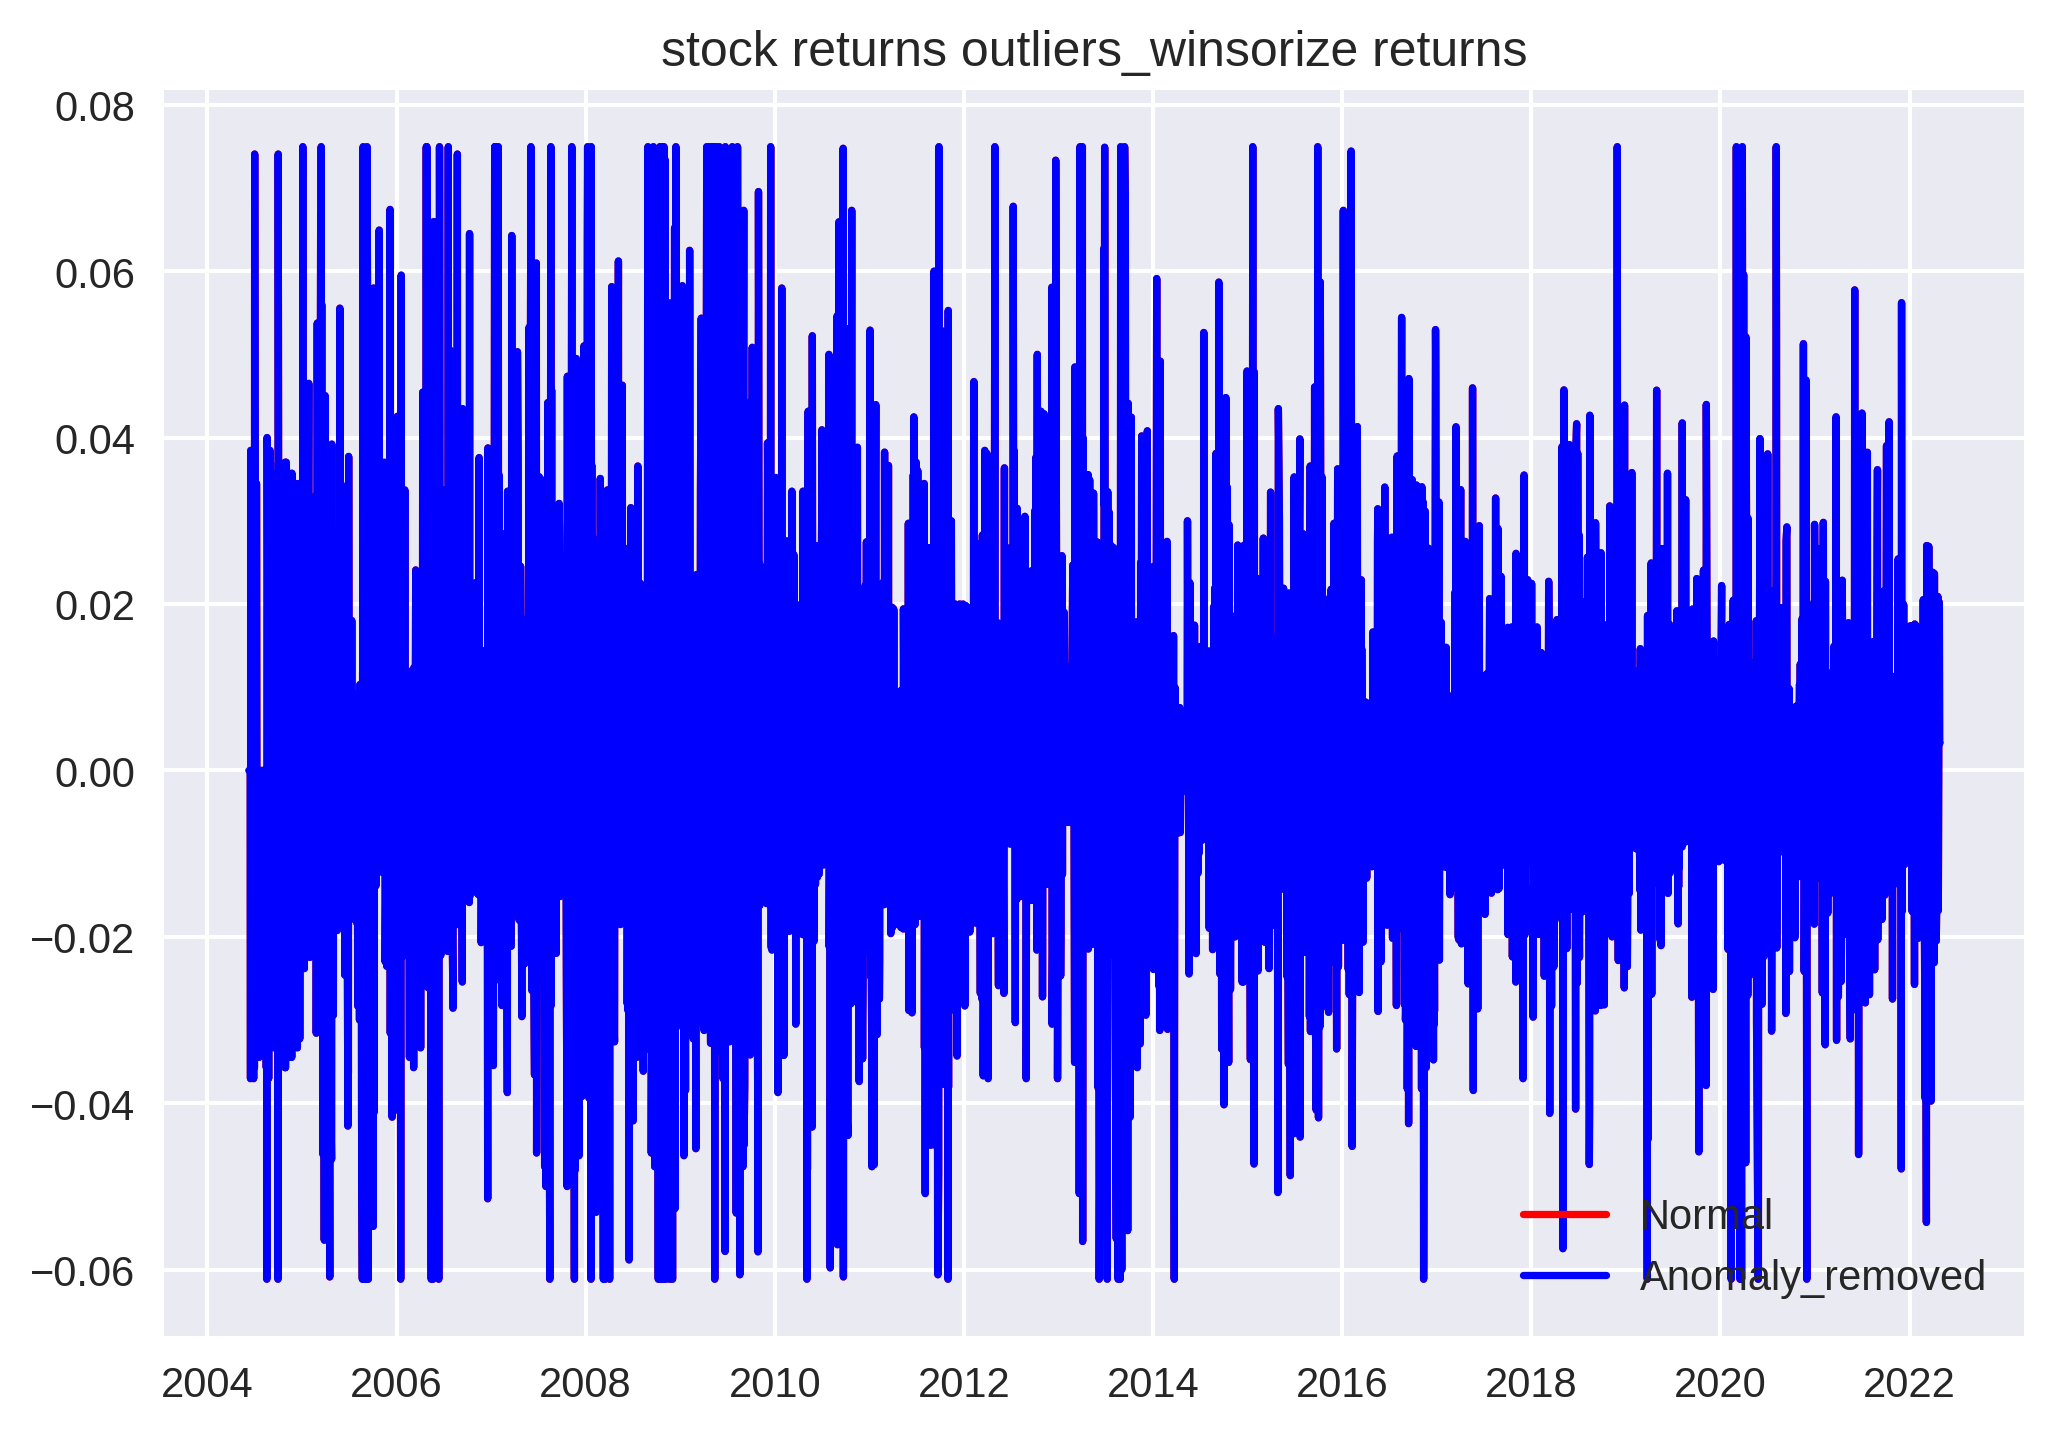

In [ ]:
fig, ax = plt.subplots()
ax.plot(d1.index, d1.simple_rtn, 
        color='red', label='Normal')
ax.plot(d1.index, d1.simple_rtn, 
        color='blue', label='Anomaly_removed')
ax.set_title("stock returns outliers_winsorize returns")
ax.legend(loc='lower right');